<pre>Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük
az alábbi szerzőt értesíteni.

Az Inception V3 modell ebben a cikkben kerül bemutatásra: 
https://arxiv.org/abs/1512.00567

A kód elkészítéséhez az alábbi források kerültek felhasználásra:
https://keras.io/applications/
https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb

2020 (c) Gyires-Tóth Bálint (toth.b kukac tmit pont bme pont hu)
</pre>

# Transfer learning

A transfer learning röviden azt jelenti, hogy egy betanított (sok esetben előtanított) háló súlyait tovább tanítjuk, jellemzően az eredeti adatbázistól eltérő adatokkal.

## Adatok le- és betöltése

Az adatokat a Google példái közül töltjük le, a teljes adatbázis a https://www.kaggle.com/c/dogs-vs-cats oldalon érhető el. Ha nem Linux rendszer alatt dolgozunk, akkor a https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip fájlt töltsd le és csomagold ki.

In [1]:
import os
import zipfile

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

--2020-10-14 09:09:29--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 2a00:1450:4013:c07::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   225MB/s    in 0.3s    

2020-10-14 09:09:30 (225 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Ezt követően készítsük rakjuk össze a könyvtárok neveit:

In [4]:
base_dir = '/tmp/cats_and_dogs_filtered' # Linux esetén
#base_dir = 'cats_and_dogs_filtered' # Windows esetén erre módosítsuk, ha a script mellé tömörítettük ki a ZIP fájlt
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.85.jpg', 'cat.210.jpg', 'cat.311.jpg', 'cat.585.jpg', 'cat.169.jpg', 'cat.560.jpg', 'cat.502.jpg', 'cat.709.jpg', 'cat.660.jpg', 'cat.877.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Vizsgáljuk meg, hogy milyenek is ezek a képek:

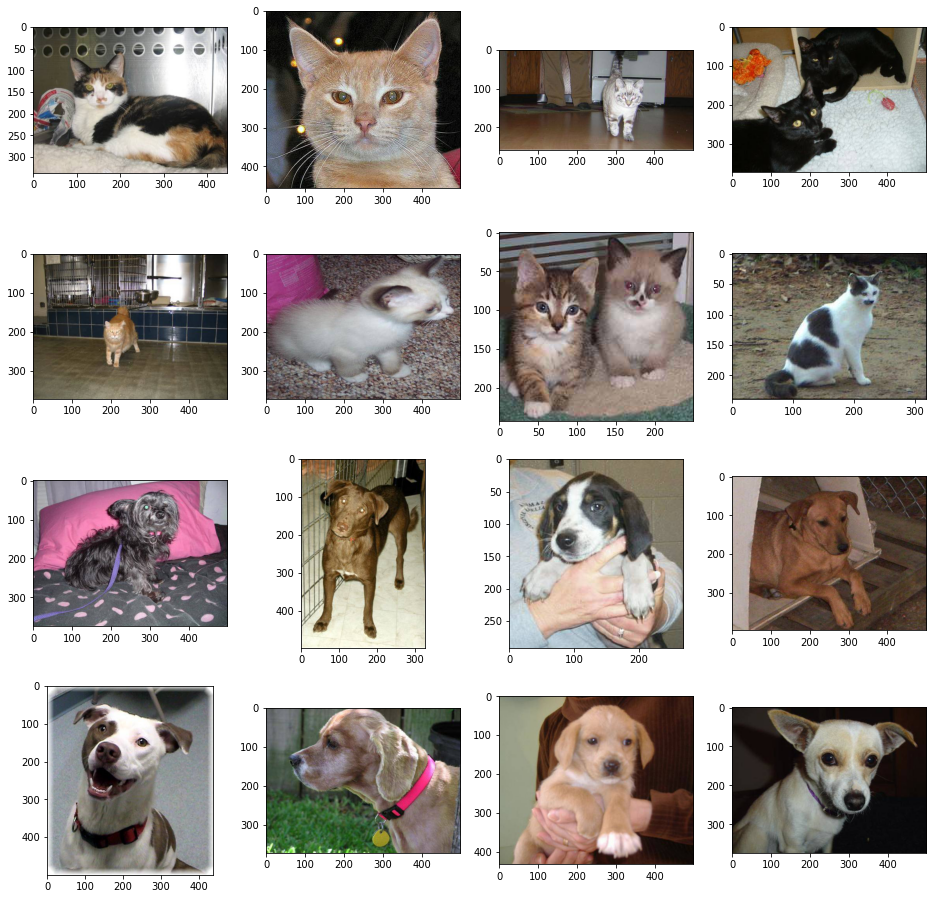

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# megadjuk, hogy hány sor és oszlop jelenjen meg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[:int(ncols*nrows/2)]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[:int(ncols*nrows/2)]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Előtanított hálózat betöltése és tovább tanítása (transfer learning)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np

In [9]:
img_height=299
img_width=299

In [10]:
# előtanított modell betöltése, a fully-connected rétegek nélkül
base_model = InceptionV3(weights='imagenet', include_top=False)
# az utolsó konvolúciós réteg utána egy global average pooling réteget teszünk, ez rögtön "lapítja" (flatten) a 2D konvolúciót
x = base_model.output
x = GlobalAveragePooling2D()(x)
# ezután hozzáadunk egy előrecsatolt réteget ReLU aktivációs függvénnyel
x = Dense(1024, activation='relu')(x)
# és végül egy kimenete lesz a hálónak - a "binary_crossentropy" költségfüggvénynek erre van szüksége
predictions = Dense(1, activation='sigmoid')(x)
# a model létrehozása
model = Model(inputs=base_model.input, outputs=predictions)

87916544/87910968 [==============================] - 3s 0us/step


Két lépésben fogjuk tanítani a hálót, az első lépésben csak az előrecsatolt rétegeket tanítjuk, a konvolúciós rétegeket befagyasztjuk.

In [11]:
for layer in base_model.layers:
    layer.trainable = False

# lefordítjuk a modelt (fontos, hogy ezt a rétegek befagyasztása után csináljuk"
# mivel két osztályunk van, ezért bináris keresztentrópia költségfüggvényt használunk
model.compile(optimizer='adam', metrics=['accuracy'],loss='binary_crossentropy')

In [12]:
# kép felkészítése a betöltésre és adatdúsításra
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# ez a függvény egyszerre végzi az adatdúsítást és a háló tanítását
model.fit_generator(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
100/200 [==============>...............] - 42s 420ms/step - loss: 0.1189 - accuracy: 0.9655 - val_loss: 0.1021 - val_accuracy: 0.9850


In [14]:
# ehhez először nézzük meg a háló felépítését
print("Az Inception V3 konvolúciós rétegei:")
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

Az Inception V3 konvolúciós rétegei:
0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normali

Ezt követően fagyasszuk be a felső rétegeket, és tanítsuk tovább a hálót, most már SGD-vel, alacsony learning rate mellett:

In [15]:
for layer in model.layers[:172]:
       layer.trainable = False
for layer in model.layers[172:]:
       layer.trainable = True

In [16]:
# ez után újra le kell fordítanunk a hálót, hogy most már az Inception V3 felsőbb rétegei tanuljanak
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'], loss='binary_crossentropy')

In [17]:
model.fit_generator(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)
print("Tanítás vége.")

Epoch 1/3
100/200 [==============>...............] - 44s 443ms/step - loss: 0.2995 - accuracy: 0.9080 - val_loss: 0.0269 - val_accuracy: 0.9850
Tanítás vége.


## Belső reprezentációk vizsgálata

Érdemes lehet vizsgálni a betanított háló konvolúciós és pooling rétegeinek a kimeneteit adott bemenet esetén.

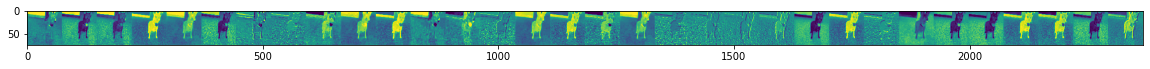

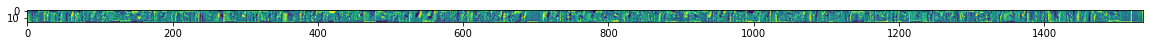

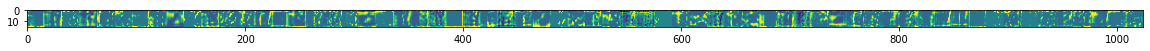

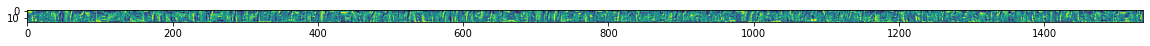

In [18]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Egy új modellt hozunk létre, ahol különböző rétegeit kötjük ki a fenti réteglista szerint a modellnek
successive_outputs = [model.layers[1].output, model.layers[30].output, model.layers[60].output, model.layers[90].output]
visualization_model = Model(base_model.input, successive_outputs)

# Válasszunk ki 10-10 képet mindkét csoportból
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Adatelőkészítés
x /= 255
# A predikció futtatása az adott rétegig
successive_feature_maps = visualization_model.predict(x)

# A reprezentációk megjelenítése rétegenként
for feature_map in successive_feature_maps:
    n_features = feature_map.shape[-1]  # a konvolúciós szűrők száma alapján készült feature map-ek
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      # A feature map-eket át kell alakítani, hogy jól láthatóak legyenek
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128        
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Garbage collector futtatása

In [19]:
import gc
gc.collect()

9344